# Contact-insulating loci

In [2]:
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-white')

In [3]:
import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler
import bbi

In [4]:
mm9 = bioframe.fetch_chromsizes('mm9')
chromsizes = bioframe.fetch_chromsizes('mm9')
chromosomes = list(chromsizes.index)

In [12]:
conditions = ['WT', 'T', 'dN']
binsize = 100000

cooler_paths = {    
    'WT' : f'data/UNTR.{binsize}.cool',
    'T'  : f'data/TAM.{binsize}.cool',
    'dN' : f'data/NIPBL.{binsize}.cool',
}
long_names = {
    'WT': 'Wildtype',
    'T' : 'TAM',
    'dN': 'NipblKO',
}
pal = sns.color_palette('colorblind')
colors = {
    'WT': pal[0],
    'T' : '#333333',
    'dN': pal[2],
}

clrs = {
    cond: cooler.Cooler(cooler_paths[cond]) for cond in conditions
}

In [13]:
from cooltools.insulation import find_insulating_boundaries
from cooltools.directionality import directionality

window_bp = binsize * 5

insul = {}
direc = {}

for cond in conditions:
    # Diamond insulation score
    insul[cond] = find_insulating_boundaries(
        clrs[cond], 
        balance='weight',
        window_bp=window_bp, 
        min_dist_bad_bin=2, 
    )
    insul[cond].to_csv(f'data/{long_names[cond]}.{binsize//1000}kb.insul_{window_bp}.tsv', sep='\t')
    bioframe.to_bigwig(insul[cond], mm9, 
                       f'data/{long_names[cond]}.{binsize//1000}kb.insul_score_{window_bp}.bw', 
                       f'log2_insulation_score_{window_bp}')
    bioframe.to_bigwig(insul[cond], mm9, 
                       f'data/{long_names[cond]}.{binsize//1000}kb.insul_pp_{window_bp}.bw', 
                       f'boundary_strength_{window_bp}')
    
    # Directionality Index
    direc[cond] = directionality(
        clrs[cond],
        window_bp=window_bp,
        min_dist_bad_bin=2,
    )
    drc.to_csv(f'data/{long_names[cond]}.{binsize//1000}kb.direc_{window_bp}.tsv', sep='\t')
    bioframe.to_bigwig(direc[cond], mm9, 
                       f'data/{long_names[cond]}.{binsize//1000}kb.direc_index_{window_bp}.bw', 
                       f'directionality_index_{window_bp}')
    bioframe.to_bigwig(direc[cond], mm9, 
                       f'data/{long_names[cond]}.{binsize//1000}kb.direc_ratio_{window_bp}.bw', 
                       f'directionality_ratio_{window_bp}')

bedGraphToBigWig /tmp/tmpg4ubrdoe.bg /tmp/tmphpypwwbf.chrom.sizes data/Wildtype.100kb.insul_score_500000.bw
bedGraphToBigWig /tmp/tmpe8qtq3w7.bg /tmp/tmpdyc2nvtv.chrom.sizes data/Wildtype.100kb.insul_pp_500000.bw
bedGraphToBigWig /tmp/tmpvndx7otc.bg /tmp/tmpqtg_jut_.chrom.sizes data/Wildtype.100kb.direc_index_500000.bw
bedGraphToBigWig /tmp/tmpfrhruq5p.bg /tmp/tmpt83ddd04.chrom.sizes data/Wildtype.100kb.direc_ratio_500000.bw
bedGraphToBigWig /tmp/tmpxe306yoi.bg /tmp/tmpwgeh7ip8.chrom.sizes data/TAM.100kb.insul_score_500000.bw
bedGraphToBigWig /tmp/tmpis7tzg77.bg /tmp/tmp6t58zl5e.chrom.sizes data/TAM.100kb.insul_pp_500000.bw
bedGraphToBigWig /tmp/tmp90t6y0ic.bg /tmp/tmpyembd_sm.chrom.sizes data/TAM.100kb.direc_index_500000.bw
bedGraphToBigWig /tmp/tmpmmyd3qq8.bg /tmp/tmpkszuwmpu.chrom.sizes data/TAM.100kb.direc_ratio_500000.bw
bedGraphToBigWig /tmp/tmpd73hacmc.bg /tmp/tmpl4sfv_il.chrom.sizes data/NipblKO.100kb.insul_score_500000.bw
bedGraphToBigWig /tmp/tmp6f5pwlcz.bg /tmp/tmp7vredqxc.c

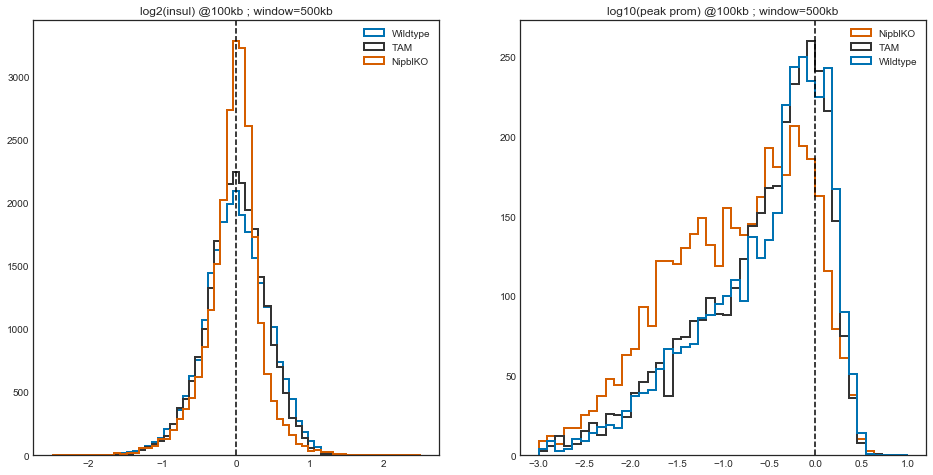

In [14]:
gs = plt.GridSpec(nrows=1, ncols=2)
plt.figure(figsize=(8*2, 8))

binedges = np.linspace(-2.5, 2.5, 60)
plt.subplot(gs[0])
for cond in conditions:
    x = insul[cond][f'log2_insulation_score_{window_bp}'].values
    plt.hist(x[~np.isnan(x)], 
             bins=binedges, 
             histtype='step', 
             lw=2, 
             label=long_names[cond], 
             color=colors[cond])
plt.axvline(0, c='k', ls='--')
plt.legend()
plt.title(f'log2(insul) @{binsize//1000}kb ; window={window_bp//1000}kb')

plt.subplot(gs[1])
binedges = np.linspace(-3, 1, 45)
for cond in conditions[::-1]:
    x = insul[cond][f'boundary_strength_{window_bp}'].apply(np.log10).values
    plt.hist(x[~np.isnan(x)], 
             bins=binedges, 
             histtype='step', 
             lw=2, 
             label=long_names[cond], 
             color=colors[cond])
plt.axvline(0, c='k', ls='--')
plt.legend()
plt.title(f'log10(peak prom) @{binsize//1000}kb ; window={window_bp//1000}kb')

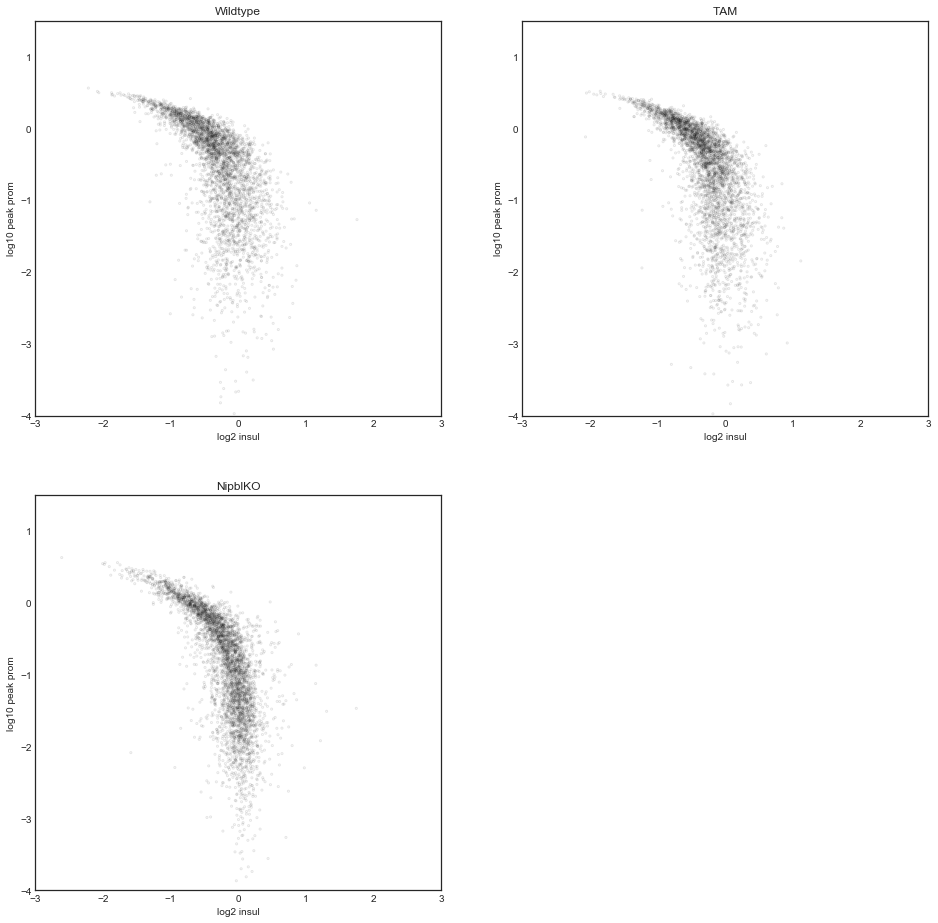

In [15]:
gs = plt.GridSpec(nrows=2, ncols=2)
plt.figure(figsize=(8*2, 8*2))

for i, cond in enumerate(conditions):
    plt.subplot(gs[i])
    plt.scatter(
        insul[cond][f'log2_insulation_score_{window_bp}'].values,
        np.log10(insul[cond][f'boundary_strength_{window_bp}']).values,
        s=4,
        edgecolor='k',
        facecolor='none',
        alpha=0.1
    )
    plt.title(long_names[cond])
    plt.xlabel('log2 insul')
    plt.ylabel('log10 peak prom')
    
    plt.xlim(-3, 3)
    plt.ylim(-4, 1.5)

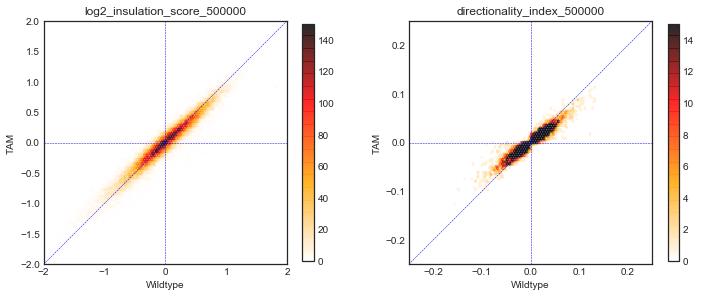

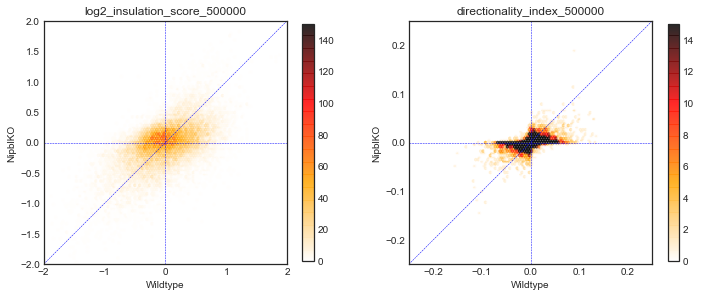

In [29]:
gs = GridSpec(nrows=2, ncols=2)

for i, (condx, condy) in enumerate([('WT', 'T'), ('WT', 'dN')]):
    
    plt.figure(figsize=(2 * 6, 2 * 6))

    score = f'log2_insulation_score_{window_bp}'
    plt.subplot(gs[i, 0])
    plt.hexbin(
        insul[condx][score],
        insul[condy][score],
        extent=(-2, 2, -2, 2),
        vmin=0,
        vmax=150,
        cmap=sns.blend_palette(['w', 'orange', 'r', 'k'], as_cmap=True),
        alpha=0.6,
        rasterized=True
    )
    plt.plot([-2, 2], [-2, 2], c='b', ls='--', lw=0.5)
    plt.axvline(0, c='b', lw=0.5, ls='--')
    plt.axhline(0, c='b', lw=0.5, ls='--')
    plt.gca().set_aspect(1)
    plt.colorbar(shrink=0.8)
    plt.xlabel(long_names[condx])
    plt.ylabel(long_names[condy])
    plt.title(score)


    score = f'directionality_index_{window_bp}'
    plt.subplot(gs[i, 1])
    plt.hexbin(
        direc[condx][score],
        direc[condy][score],
        extent=(-0.25, 0.25, -0.25, 0.25),
        vmin=0,
        vmax=15,
        cmap=sns.blend_palette(['w', 'orange', 'r', 'k'], as_cmap=True),
        alpha=0.6,
        rasterized=True
    )
    plt.plot([-0.25, 0.25], [-0.25, 0.25], c='b', ls='--', lw=0.5)
    plt.axvline(0, c='b', lw=0.5, ls='--')
    plt.axhline(0, c='b', lw=0.5, ls='--')
    plt.gca().set_aspect(1)
    plt.colorbar(shrink=0.8)
    plt.xlabel(long_names[condx])
    plt.ylabel(long_names[condy])
    plt.title(score)


In [31]:
peaks = {}
pscore = f'boundary_strength_{window_bp}'
cols = ['chrom', 'start', 'end', pscore]
for cond in conditions:
    peaks[cond] = (
        insul[cond].dropna(subset=[pscore])[cols]
                   .sort_values(pscore, ascending=False) # peaks!
    )
wt_peaks = peaks['WT']
len(peaks['WT']), len(peaks['T']), len(peaks['dN'])

(3457, 3537, 3968)

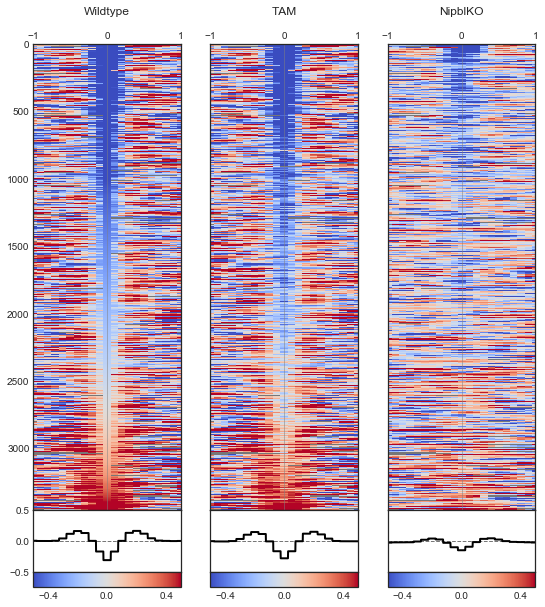

In [40]:
stacks = {}
nbins = 2000
for i, cond in enumerate(conditions):
    mids = (wt_peaks['start'] + wt_peaks['end']) // 2
    flank = 1000000
    bwfile = f'data/{long_names[cond]}.100kb.insul_score_500000.bw'
    #bwfile = f'data/{long_names[cond]}.100kb.direc_ratio_500000.bw'
    #bwfile = f'data/{long_names[cond]}.100kb.eigs.cis.vecs.E1.bw'
    stacks[cond] = bbi.stackup(bwfile, wt_peaks['chrom'], mids - flank, mids + flank, bins=nbins)

    
gs = GridSpec(nrows=3, ncols=len(conditions), 
              height_ratios=[15, 2, 0.5], 
              hspace=0)

plt.figure(figsize=(3*len(conditions), 10))

X = stacks['WT']
idx = np.argsort(X[:, X.shape[1]//2])
x = np.linspace(-flank/1e6, flank/1e6, nbins)
cmap = plt.cm.get_cmap('coolwarm')
cmap.set_bad('#777777')
im_opts = dict(
    vmin=-0.5, 
    vmax=0.5,
    extent=[-flank/1e6, flank/1e6, len(wt_peaks), 0],
    cmap=cmap
)

for i, name in enumerate(stacks):
    # heatmap
    ax = ax1 = plt.subplot(gs[0, i])
    X = stacks[name]
    img = ax.matshow(X[idx, :], **im_opts, rasterized=True)
    ax.axvline(0, c='grey', lw=0.5)
    ax.grid('off')
    ax.set_aspect('auto')
    ax.set_title(long_names[name])
    if i > 0:
        ax.yaxis.set_visible(False)
    
    # summary
    ax = plt.subplot(gs[1, i], sharex=ax1)    
    ax.axhline(0, c='#777777', lw=1, ls='--')
    ax.plot(x, np.nanmean(stacks[name], axis=0), c='k', lw=2)
    ax.set_xlim(-flank/1e6, flank/1e6)
    ax.xaxis.set_visible(False)
    ax.set_ylim(-0.5, 0.5)
    if i > 0:
        ax.yaxis.set_visible(False)
    
    # color bar
    cax = plt.subplot(gs[2, i])
    cb = plt.colorbar(img, cax=cax, orientation='horizontal')
    cb.locator = mpl.ticker.MaxNLocator(nbins=3)
    cb.update_ticks()

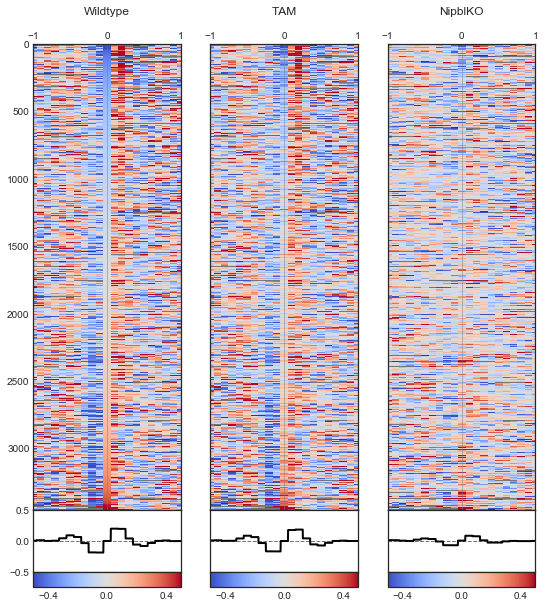

In [41]:
stacks = {}
nbins = 2000
for i, cond in enumerate(conditions):
    mids = (wt_peaks['start'] + wt_peaks['end']) // 2
    flank = 1000000
    bwfile = f'data/{long_names[cond]}.100kb.direc_ratio_500000.bw'
    stacks[cond] = bbi.stackup(bwfile, wt_peaks['chrom'], mids - flank, mids + flank, bins=nbins)

    
gs = GridSpec(nrows=3, ncols=len(conditions), 
              height_ratios=[15, 2, 0.5], 
              hspace=0)

plt.figure(figsize=(3*len(conditions), 10))

X = stacks['WT']
idx = np.argsort(X[:, X.shape[1]//2])
x = np.linspace(-flank/1e6, flank/1e6, nbins)
cmap = plt.cm.get_cmap('coolwarm')
cmap.set_bad('#777777')
im_opts = dict(
    vmin=-0.5, 
    vmax=0.5,
    extent=[-flank/1e6, flank/1e6, len(wt_peaks), 0],
    cmap=cmap
)

for i, name in enumerate(stacks):
    # heatmap
    ax = ax1 = plt.subplot(gs[0, i])
    X = stacks[name]
    img = ax.matshow(X[idx, :], **im_opts, rasterized=True)
    ax.axvline(0, c='grey', lw=0.5)
    ax.grid('off')
    ax.set_aspect('auto')
    ax.set_title(long_names[name])
    if i > 0:
        ax.yaxis.set_visible(False)
    
    # summary
    ax = plt.subplot(gs[1, i], sharex=ax1)    
    ax.axhline(0, c='#777777', lw=1, ls='--')
    ax.plot(x, np.nanmean(stacks[name], axis=0), c='k', lw=2)
    ax.set_xlim(-flank/1e6, flank/1e6)
    ax.xaxis.set_visible(False)
    ax.set_ylim(-0.5, 0.5)
    if i > 0:
        ax.yaxis.set_visible(False)
    
    # color bar
    cax = plt.subplot(gs[2, i])
    cb = plt.colorbar(img, cax=cax, orientation='horizontal')
    cb.locator = mpl.ticker.MaxNLocator(nbins=3)
    cb.update_ticks()